# Manipulations d'Images Fondamentales avec NumPy

Ce chapitre explore diverses techniques de manipulation d'images en utilisant NumPy. En traitant les images comme des tableaux numériques, nous pouvons appliquer des opérations arithmétiques et logiques pour créer des effets visuels, recadrer, retourner et transformer les images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import imageio.v2 as iio


---

## Chargement d'une image locale

Nous allons charger une image depuis le système de fichiers local pour les manipulations.

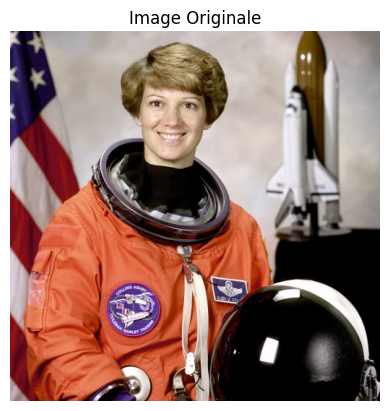

In [2]:
try:
    image = iio.imread('data/man_computer_smiling.jpg')
except FileNotFoundError:    print("Erreur : Le fichier 'man_computer_smiling.jpg' est introuvable dans le dossier 'data'. Utilisation d'une image de secours.")
image = data.astronaut() # Image de secours

plt.imshow(image)
plt.title("Image Originale")
plt.axis('off')
plt.show()

---

## 1. Recadrage (cropping)

Le recadrage d'une image consiste à extraire une sous-région rectangulaire. Cette opération est réalisée en utilisant le *slicing* sur les dimensions de hauteur et de largeur du tableau NumPy.

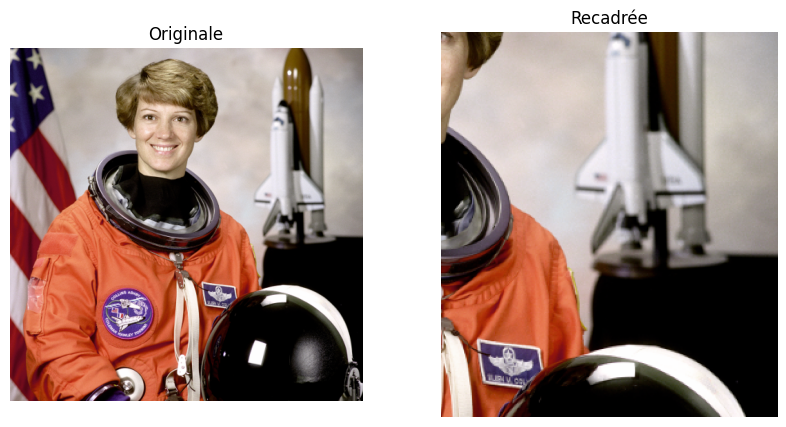

In [3]:
# Slicing sur les dimensions de hauteur et de largeur
# Exemple : lignes de 100 à 400, colonnes de 250 à 550
image_recadree = image[100:400, 250:550, :]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Originale")
axes[0].axis('off')

axes[1].imshow(image_recadree)
axes[1].set_title("Recadrée")
axes[1].axis('off')
plt.show()

---

## 2. Transformations géométriques : rotation et retournement

NumPy fournit des fonctions pour effectuer des transformations géométriques simples sur les tableaux, telles que le retournement et la rotation.
-   `np.fliplr()` : Retournement horizontal (gauche-droite).
-   `np.flipud()` : Retournement vertical (haut-bas).
-   `np.rot90()` : Rotation de 90 degrés dans le sens anti-horaire.

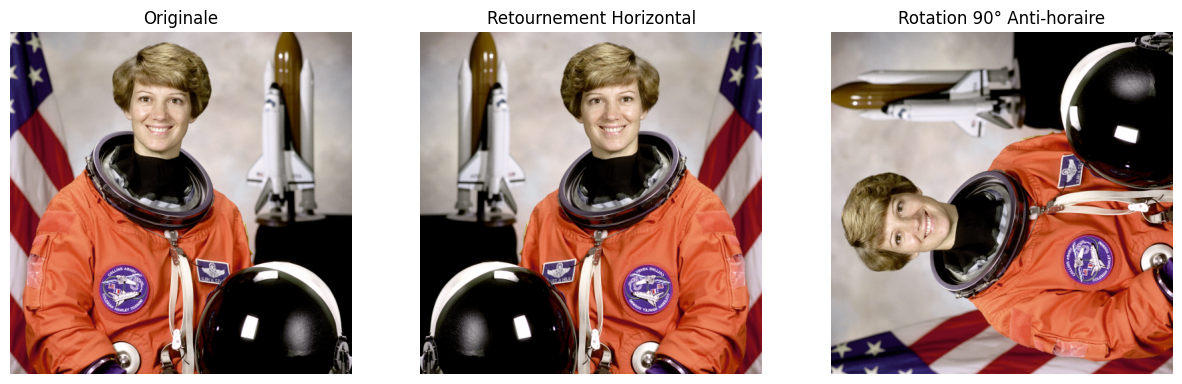

In [4]:
image_retournee_lr = np.fliplr(image)
image_rot_90 = np.rot90(image)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Originale")
axes[0].axis('off')

axes[1].imshow(image_retournee_lr)
axes[1].set_title("Retournement Horizontal")
axes[1].axis('off')

axes[2].imshow(image_rot_90)
axes[2].set_title("Rotation 90° Anti-horaire")
axes[2].axis('off')
plt.show()

---

## 3. Seuillage (Binarisation)

Le seuillage est une opération qui transforme une image en niveaux de gris en une image binaire, où chaque pixel est soit noir, soit blanc. Cette technique est souvent utilisée pour isoler des objets d'intérêt.

**Processus :**
1.  Conversion de l'image en niveaux de gris.
2.  Définition d'une valeur de seuil.
3.  Application d'une condition : les pixels dont l'intensité est supérieure au seuil deviennent blancs (255), les autres deviennent noirs (0).

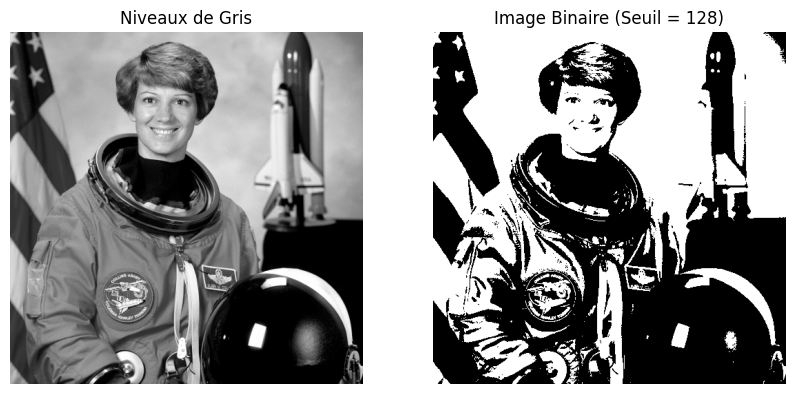

In [5]:
image_gris = np.mean(image, axis=2).astype(np.uint8)

seuil = 128
image_seuillee = np.where(image_gris > seuil, 255, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_gris, cmap='gray')
axes[0].set_title("Niveaux de Gris")
axes[0].axis('off')

axes[1].imshow(image_seuillee, cmap='gray')
axes[1].set_title(f"Image Binaire (Seuil = {seuil})")
axes[1].axis('off')
plt.show()

---

## 4. Inversion de Couleurs (Effet Négatif)

L'effet négatif est obtenu en soustrayant la valeur de chaque pixel de la valeur maximale possible (généralement 255 pour les images 8 bits). Cela inverse les couleurs, transformant le noir en blanc, le blanc en noir, et les couleurs en leurs complémentaires.

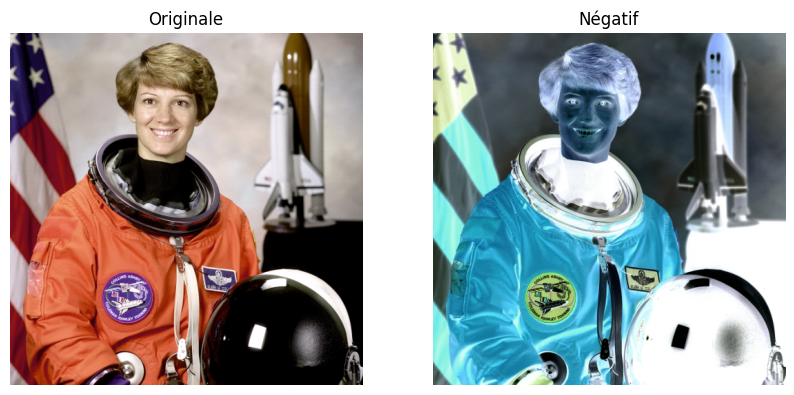

In [6]:
image_negative = 255 - image

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Originale")
axes[0].axis('off')

axes[1].imshow(image_negative)
axes[1].set_title("Négatif")
axes[1].axis('off')
plt.show()

---

## 5. Filtre Sépia

Le filtre sépia confère à une image une teinte chaude et monochrome, évoquant un aspect ancien. Il est appliqué en transformant les valeurs RVB de chaque pixel à l'aide d'une matrice de conversion spécifique.

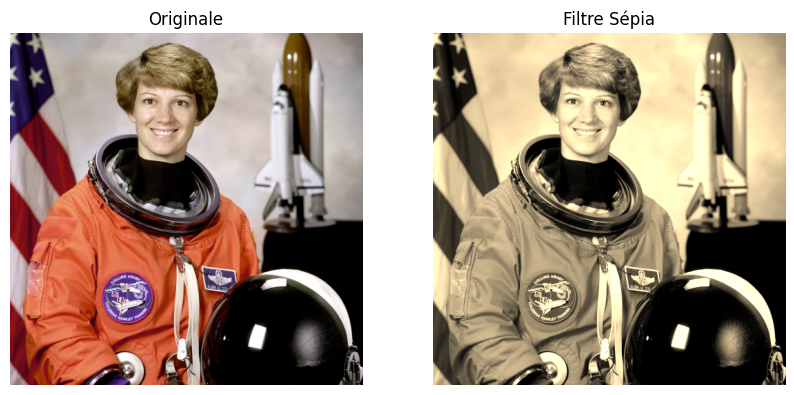

In [7]:
# Conversion de l'image en flottants pour les calculs matriciels
image_float = image.astype(np.float64)

# Matrice de transformation pour l'effet sépia
sepia_matrix = np.array([
    [0.393, 0.769, 0.189],
    [0.349, 0.686, 0.168],
    [0.272, 0.534, 0.131]
])

# Application de la transformation matricielle
image_sepia_float = image_float @ sepia_matrix.T

# S'assurer que les valeurs restent dans la plage [0, 255] et reconvertir en entier 8 bits
image_sepia = np.clip(image_sepia_float, 0, 255).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Originale")
axes[0].axis('off')

axes[1].imshow(image_sepia)
axes[1].set_title("Filtre Sépia")
axes[1].axis('off')
plt.show()